In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
from operator import itemgetter
import copy
import numpy as np

# intro: load example graph

In [23]:
import pyximport
import helloworld


In [26]:
import elbow_cython

In [27]:
elbow_cython.elbow_cython(2000)


TypeError: 'int' object is not iterable

In [ ]:
elbow_cython

/home/jaime/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/jaime/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


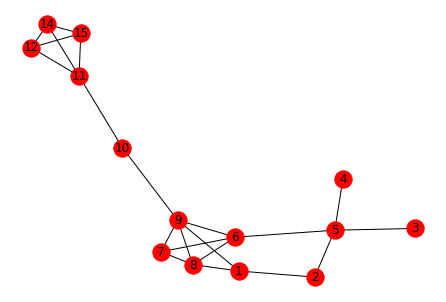

In [2]:
g = nx.Graph([])
g.add_edges_from([(1,2),(1,8),(1,9),
                  (5,2),
                  (5,3),
                  (5,4),
                  (5,6),
                  (6,7),
                  (6,8),
                  (6,9),
                  (7,8),
                  (7,9),
                  (8,9),
                  (9,10),
                  (10,11),
                  (11,14),
                  (11,15),
                  (11,12),
                  (14,15),
                  (15,12),
                  (12,14)
                 ])
nx.draw(g,with_labels=True)
plt.show()

# naive algo

In [351]:
def elbow(sorted_scores):
    sorted_scores = [np.array(i) for i in sorted_scores]
    #traduit de R, du code de l'article original
    if len(sorted_scores)<3:
        elbow_point=1
    else:
         # first point
        first_point = sorted_scores[0]
         # last point
        last_point =sorted_scores[-1]
        
        # compute distance between each point of "sorted_scores" and the "first-last" line
        distances = []
    
        for index,point in enumerate(sorted_scores):
            point= np.array(point)
            #calculate distance between the point and the line drawn between first point and last point
            d=np.cross(last_point-first_point,point-first_point)/np.linalg.norm(last_point-first_point)
            distances.append(abs(d))
            
        #print(distances)
        if np.max(distances)>0:
            x_elbow=sorted_scores[np.argmax(distances)]
        else :
            x_elbow=sorted_scores[0]
            
            
        return x_elbow


In [356]:
def get_density(g):
    e = g.number_of_edges()
    v = g.number_of_nodes()

    if v !=0:
        density = abs(e)/(abs(v)*(abs(v)-1))
        return density
    else : 
        return None

def dens_method(k_core_decomp):
    D=[]
    for i in range(max(k_core_decomp.values())):
        nodes_indexes = [k for k, v in k_core_decomp.items() if v >i]
        g_small = g.subgraph(nodes_indexes)
        D.append(get_density(g_small))
    return elbow([i for i in enumerate(D)])[0]+1 # +1 as we started counting at zero

def get_keywords(g):
    k_core_decomp = nx.core_number(g) # replace by custom made function
    k_core_value_of_keywords = dens_method(k_core_decomp)
    keywords = [k for k, v in k_core_decomp.items() if v >= k_core_value_of_keywords]
    return keywords

# def get_keywords_cython(g):
#     k_core_decomp = nx.core_number(g) # replace by custom made function
#     k_core_value_of_keywords = dens_method(k_core_decomp)
#     keywords = [k for k, v in k_core_decomp.items() if v >= k_core_value_of_keywords]
#     return keywords

In [357]:
def get_keywords_cython(g):
    k_core_decomp = nx.core_number(g) # replace by custom made function
    k_core_value_of_keywords = dens_method(k_core_decomp)
    keywords = [k for k, v in k_core_decomp.items() if v >= k_core_value_of_keywords]
    return keywords

In [358]:
get_keywords(g)

[1, 2, 8, 9, 5, 6, 7, 10, 11, 14, 15, 12]

In [359]:
c_get_keywords(g)

[0.11538461538461539, 0.14393939393939395, 0.21428571428571427]
0.0
-0.04179154336452484
0.0
[0.0, 0.020870269634832447, 0.0]


[1, 2, 8, 9, 5, 6, 7, 10, 11, 14, 15, 12]

# Now in Cython

In [327]:
%%cython -a
import numpy as np

# We now need to fix a datatype for our arrays. I've used the variable
# DTYPE for this, which is assigned to the usual NumPy runtime
# type info object.
DTYPE = np.intc


def compute(array_1, array_2, int a, int b, int c):
    
    # The "cdef" keyword is also used within functions to type variables. It
    # can only be used at the top indentation level (there are non-trivial
    # problems with allowing them in other places, though we'd love to see
    # good and thought out proposals for it).
    cdef Py_ssize_t x_max = array_1.shape[0]
    cdef Py_ssize_t y_max = array_1.shape[1]
    
    assert array_1.shape == array_2.shape
    assert array_1.dtype == DTYPE
    assert array_2.dtype == DTYPE

    result = np.zeros((x_max, y_max), dtype=DTYPE)
    
    # It is very important to type ALL your variables. You do not get any
    # warnings if not, only much slower code (they are implicitly typed as
    # Python objects).
    # For the "tmp" variable, we want to use the same data type as is
    # stored in the array, so we use int because it correspond to np.intc.
    # NB! An important side-effect of this is that if "tmp" overflows its
    # datatype size, it will simply wrap around like in C, rather than raise
    # an error like in Python.

    cdef int tmp
    cdef Py_ssize_t x, y

    for x in range(x_max):
        for y in range(y_max):

            tmp = clip(array_1[x, y], 2, 10)
            tmp = tmp * a + array_2[x, y] * b
            result[x, y] = tmp + c

    return result


Error compiling Cython file:
------------------------------------------------------------
...
    cdef Py_ssize_t x, y

    for x in range(x_max):
        for y in range(y_max):

            tmp = clip(array_1[x, y], 2, 10)
                 ^
------------------------------------------------------------

/home/jaime/.cache/ipython/cython/_cython_magic_4dec9846660b7cb35467214f52039903.pyx:39:18: undeclared name not builtin: clip


TypeError: object of type 'NoneType' has no len()

In [343]:
%%cython -a
import numpy as np
import networkx as nx

cdef float cross_prod(float Ax, float Ay, float Bx, float By):
    cdef float result= Ax*By-Ay*By
    return result
def func():
    print(cross_prod())


Error compiling Cython file:
------------------------------------------------------------
...

cdef float cross_prod(float Ax, float Ay, float Bx, float By):
    cdef float result= Ax*By-Ay*By
    return result
def func():
    print(cross_prod([1,2],[2,3]))
                   ^
------------------------------------------------------------

/home/jaime/.cache/ipython/cython/_cython_magic_efd078749a28145a589cb886e186a904.pyx:8:20: Call with wrong number of arguments (expected 4, got 2)


TypeError: object of type 'NoneType' has no len()

In [342]:
np.cross([1,2],[2,3])

array(-1)

In [391]:
%%cython -a
import numpy as np
import networkx as nx

cdef float cross_prod(float Ax, float Ay, float Bx, float By):
    
    cdef float result= Ax*By-Ay*Bx
#     cdef float norm = sqrt(pow(Ax,2)+pow(Ay,2))
    return result

def c_elbow(sorted_scores):
    
#     cdef int [:, :] sorted_scores = srted_arra
    
    # We now need to fix a datatype for our arrays. I've used the variable
    # DTYPE for this, which is assigned to the usual NumPy runtime
    # type info object.
    DTYPE = np.intc
    cdef int elbow_point
    
#     sorted_scores = [np.array(i) for i in sorted_scores]
    
    cdef Py_ssize_t len_array = len(sorted_scores)
    
    #traduit de R, du code de l'article original
    if (len_array<3):
        elbow_point=1
    else:
         # first point
        
        first_point = np.array(sorted_scores[0])#.astype(np.intc)
        
         # last point
        last_point = np.array(sorted_scores[-1])#.astype(np.intc)
        
        # compute distance between each point of "sorted_scores" and the "first-last" line
        distances = []
        
        for index,point in enumerate(sorted_scores):
            point= np.array(point)
            a = cross_prod(
                last_point[0]-first_point[0],
                last_point[1]-first_point[1],
                point[0]-first_point[0],
                point[1]-first_point[1])
    
            #print(a)
                
            
            #calculate distance between the point and the line drawn between first point and last point
            d=a/np.linalg.norm(last_point-first_point)
            distances.append(abs(d))
        
            
            
#             d=np.cross(last_point-first_point,point-first_point)/np.linalg.norm(last_point-first_point)
#             distances.append(abs(d))
            
        if np.max(distances)>0:
            x_elbow=sorted_scores[np.argmax(distances)]
        else :
            x_elbow=sorted_scores[0]
        #print(distances)
        return x_elbow
    
def c_get_density(g):
    e = g.number_of_edges()
    v = g.number_of_nodes()

    if v !=0:
        density = abs(e)/(abs(v)*(abs(v)-1))
        return density
    else : 
        return None




In [392]:
def c_dens_method(k_core_decomp):
    D=[]
    for i in range(max(k_core_decomp.values())):
        nodes_indexes = [k for k, v in k_core_decomp.items() if v >i]
        g_small = g.subgraph(nodes_indexes)
        D.append(c_get_density(g_small))
#     print(D)
    final_array = np.array([i for i in enumerate(D)])#.astype(np.intc)
    
    return c_elbow(final_array)[0]+1 # +1 as we started counting at zero

def c_get_keywords(g):
    k_core_decomp = nx.core_number(g) # replace by custom made function
    k_core_value_of_keywords = c_dens_method(k_core_decomp)
    keywords = [k for k, v in k_core_decomp.items() if v >= k_core_value_of_keywords]
    return keywords



In [393]:
get_keywords(g)

[1, 2, 8, 9, 5, 6, 7, 10, 11, 14, 15, 12]

In [394]:
c_get_keywords(g)

[1, 2, 8, 9, 5, 6, 7, 10, 11, 14, 15, 12]

## time

In [ ]:
G = nx.duplication_divergence_graph(50,0.9)

In [ ]:
%timeit get_keywords(G)

In [ ]:
%timeit c_get_keywords(G)

## memory usage

In [9]:
# pip install memory_profiler

In [10]:
%load_ext memory_profiler

In [11]:
%memit get_keywords(g)

peak memory: 117.79 MiB, increment: 0.05 MiB
